In [1]:
from multiprocessing import Process
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm

import cv2
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from PIL import Image, ImageDraw

from patchify import patchify, unpatchify


from sklearn.feature_extraction import image

import json

from subprocess import run, DEVNULL

from torch.nn import Sequential, Sigmoid
from torch import from_numpy, inference_mode
from torch.nn import DataParallel

from monai.networks.nets import SwinUNETR
from monai.inferers import sliding_window_inference

from pytorch_lightning import LightningModule

from zipfile import ZipFile
from zipfile import BadZipFile
from zipfile import is_zipfile

import xmltodict

import time

import os
from os.path import join, exists, getsize, isfile

In [137]:
class NetcdfProduct:
    def __init__(self, product, image_variable='Sigma0_VV_db'):
        self.product = product
        self.name = product.filepath().split("/")[-1].split(".")[0]
        self.image_variable = image_variable

    @property
    def nc_img(self):
        return self.product.variables[self.image_variable][:]
    

    def polygons_to_img(self, json_path, dict_label, no_land_path=None, land_name="land"):
        with open(json_path, 'r') as f:
            json_labelme = json.load(f)

        dict_patches = {key: [] for key in dict_label.keys()}
        height = json_labelme['imageHeight']
        width = json_labelme['imageWidth']
        mask_array = np.where(self.nc_img.mask, np.nan, 0)

        for shapes in json_labelme["shapes"]:
            for number, name in dict_label.items():
                if shapes['label'] in name:
                    points = np.array(shapes['points'], dtype=int)
                    dict_patches[number].append(points)

        if no_land_path:
            land_label = list(np.load(no_land_path).values())
            for number, name in dict_label.items():
                if land_name in name:
                    dict_patches[number] = land_label

        for index, polygons in dict_patches.items():
            mask_array = cv2.fillPoly(mask_array, polygons, color=index)
        return mask_array
    
    def __str__(self):
        return self.name

    def create_img(self, folder_path):
        img_path = join(folder_path, self.name + ".png")
        normalized_img = ((self.nc_img - np.min(self.nc_img)) / (np.max(self.nc_img) - np.min(self.nc_img))) * 255
        cv2.imwrite(img_path, normalized_img)
    
    @staticmethod
    def create_polygons(mask):
        edited_contours = []
        binary_image = np.array(mask)
        
        contours, hierarchy = cv2.findContours(binary_image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for poly in contours:
            if len(poly) > 50:
                approx = cv2.approxPolyDP(poly, 0.8, True)
                approx = np.squeeze(approx)
                edited_contours.append(approx)
        return edited_contours
    
    @staticmethod
    def mask_to_bool(probs, threshold=0.5):
        mask = np.asarray(probs)
        mask[mask > threshold] = True
        mask[mask < threshold] = False
        return mask

    def land_mask(self, gptpath, xmlfile):
        with open(xmlfile, 'r') as f:
            dados = xmltodict.parse(f.read())

        output_file = "/mnt/camobi_2/PHMG/Sentinel_Acquisition/no_land/land.nc"

        dados['graph']['node'][0]['parameters']['file'] = self.product.filepath() 
        dados['graph']['node'][-1]['parameters']['file'] = output_file

        with open(xmlfile, 'w') as arquivo:
            arquivo.write(xmltodict.unparse(dados, pretty=True))

        shell = run([gptpath, xmlfile])#, stdout=DEVNULL, stderr=DEVNULL)
        mask_netcdf = NetcdfProduct(nc.Dataset(output_file))
        #return mask_netcdf.nc_img.mask
        mask_output = mask_netcdf.nc_img.mask
        del mask_netcdf
        os.remove(output_file)
        time.sleep(1)
        return mask_output ^ self.nc_img.mask

    def save_land_mask(self, folder, gptpath, xmlfile, simplify=2, limiar=100):
        land_mask = self.land_mask(gptpath, xmlfile)
        contours, hierarchy = cv2.findContours(land_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        edited_contours = []
        for poly in contours:
            if len(poly) > limiar:
                approx = cv2.approxPolyDP(poly, simplify, True)
                approx = np.squeeze(approx)
                print(f"Original: {len(poly)}; Simplification: {len(approx)}" )
                edited_contours.append(approx)
        np.savez(join(folder,"no_land_" + self.name), *edited_contours)

    def patches_2D(self, size, label):
        chanel_img = np.stack([self.nc_img, label], axis=-1)
        pad_array = np.repeat(int(size/2), chanel_img.shape[-1])
        zero_pad = np.repeat(0, chanel_img.shape[-1])
        chanel_img = np.pad(chanel_img, (pad_array, pad_array, zero_pad), constant_values=np.nan)

        patches = patchify(chanel_img, (size, size, chanel_img.shape[-1]), size)
        return np.squeeze(patches)
    
    def patches_1D(self, size, label):
        patches = self.patches_2D(size, label)
        patches = patches.reshape(-1, size, size, patches.shape[-1])
        return patches

    def dict_pathes(self, size, label, dict_label, label_pos=1):
        dict_patches = {key: [] for key in dict_label.keys()}
        patches = self.patches_1D(size, label)
        for patch in patches:
            for key, list in dict_patches.items():
                label_patch = np.array(patch[:,:, label_pos], dtype="uint8")
                if np.any(label_patch == key) and np.all(~np.isnan(label_patch)): #choosing the last chanel to append in dict
                    dict_patches[key].append(patch)
                    break
                    
        return dict_patches

    def probs_to_labelme(self, probs, folder, threshold=0.5):
        mask = NetcdfProduct.mask_to_bool(probs, threshold)
        masked_polygons = NetcdfProduct.create_polygons(mask)
        labelme_format = {"version": "5.1.1",
                          "flags": {},
                          "shapes": [],
                          "imagePath": f"..\\Sar_img\\{self.name}.png",  # Update with your image filename
                          "imageData": None,
                          "imageHeight": self.product.dimensions["y"].size,
                          "imageWidth": self.product.dimensions["x"].size
                          }

        for patch in masked_polygons:
            labelme_format["shapes"].append({
                "label": "oil", 
                "points": patch.squeeze().tolist(),
                "group_id": None,
                "description": "",
                "shape_type": "polygon",
                "flags": {}
            })

        auto_labels_path = join(folder, f"{self.name}.json")
        with open(auto_labels_path, 'w') as json_file:
            json.dump(labelme_format, json_file, indent=2)
        print(f"Label \"{self.name}.json\" created!")


In [138]:
dict_label = {1: ['oil'], 
              2: ['land'], 
              3: ['dark-ocean'], 
              4: ['dark-land'], 
              5: ['low-wind'], 
              6: ['ship'],
              0: ['ocean']}

In [158]:
#numpy_mask = NetcdfProduct.polygons_to_img("/mnt/camobi_3/new_data/labels_json/6CA9.json", dict_label, "/mnt/camobi_2/PHMG/Sentinel_Acquisition/no_land/no_land_6CA9.npz")
PATH_TO_GPT = "/home/camobi/snap/bin/gpt"
NO_LAND = "/mnt/camobi_2/PHMG/Sentinel_Acquisition/graphs/NO_LAND.xml"
NC_FOLDER = "/mnt/camobi_3/new_data/images_nc"
nc_name = "D0F5.nc"
ncfile_path = join(NC_FOLDER, nc_name)
netcdf_obj = NetcdfProduct(nc.Dataset(ncfile_path, 'r'))
numpy_mask = netcdf_obj.polygons_to_img(f"/mnt/camobi_3/new_data/labels_json/{nc_name[:-3]}.json", dict_label, f"/mnt/camobi_2/PHMG/Sentinel_Acquisition/no_land/no_land_{nc_name[:-3]}.npz")
test = netcdf_obj.dict_pathes(512, numpy_mask, dict_label)


/tmp/ipykernel_23865/1155419229.py:118: RuntimeWarning: invalid value encountered in cast
  label_patch = np.array(patch[:,:, label_pos], dtype="uint8")


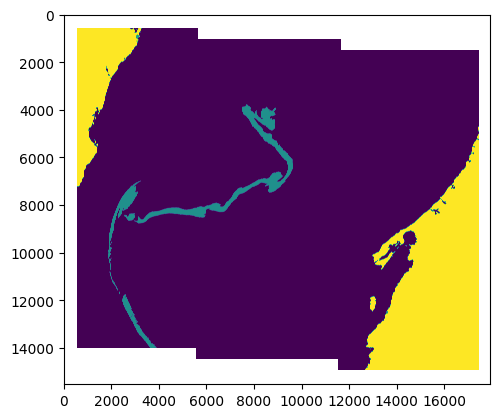

In [159]:
plt.imshow(np.pad(numpy_mask, 512, constant_values=np.nan))

dict_keys([1, 2, 3, 4, 5, 6, 0])
67


IndexError: list index out of range

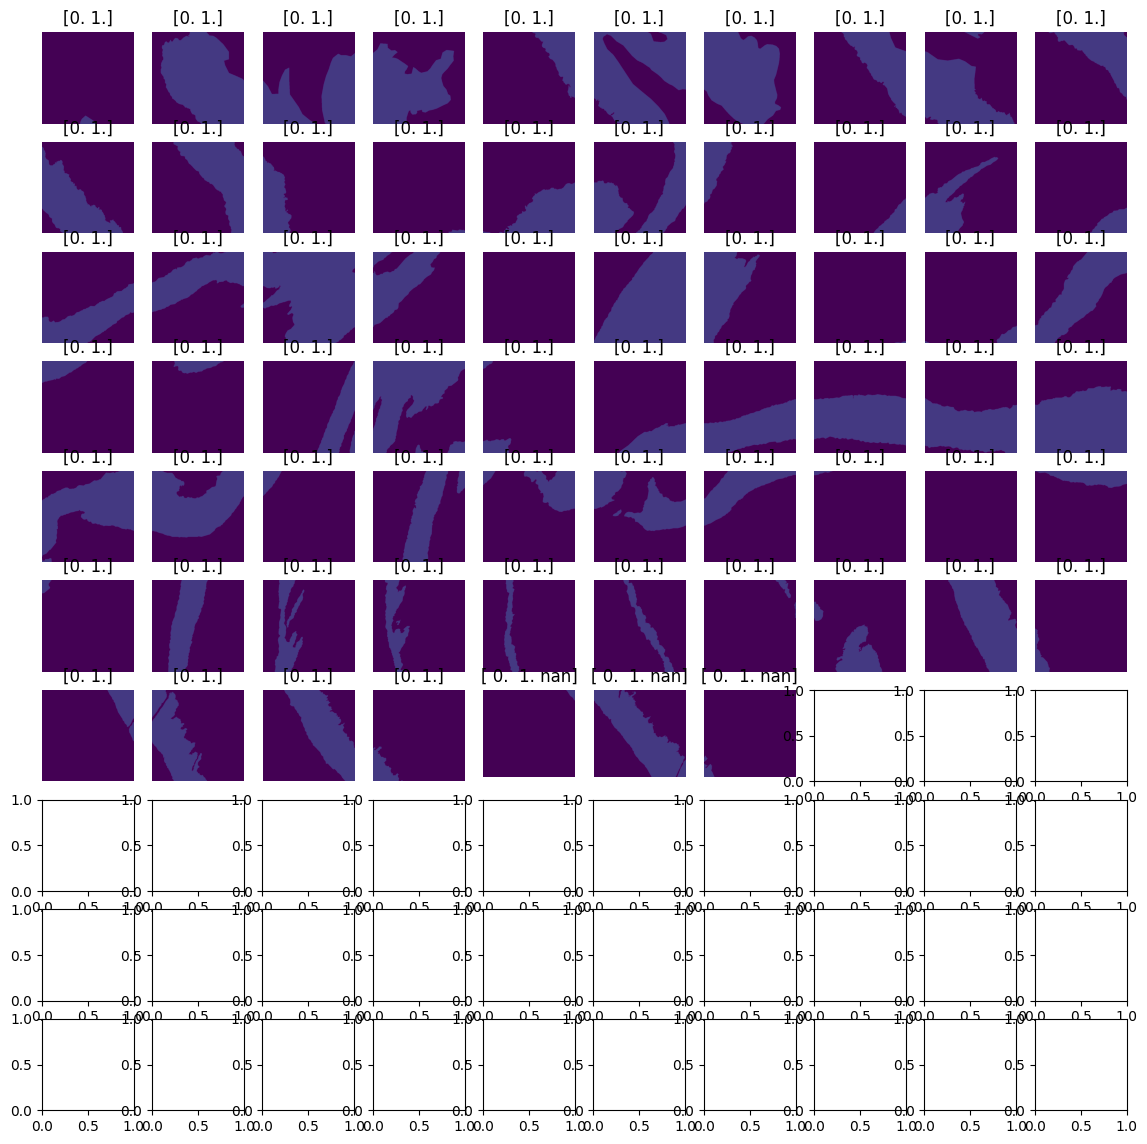

In [164]:
fig, axs = plt.subplots(ncols=10, nrows=10)
print(test.keys())
print(len(test[1]))
fig.set_size_inches(14, 14)


for index, ax in enumerate(axs.flatten()):
    ax.imshow(test[1][index][:, :, 1], vmin=0, vmax=6)
    ax.set_title(np.unique(test[1][index][:, :, 1]))
    ax.axis("off")

In [136]:
np.any(np.array([0,2]) == 1) 

False

2


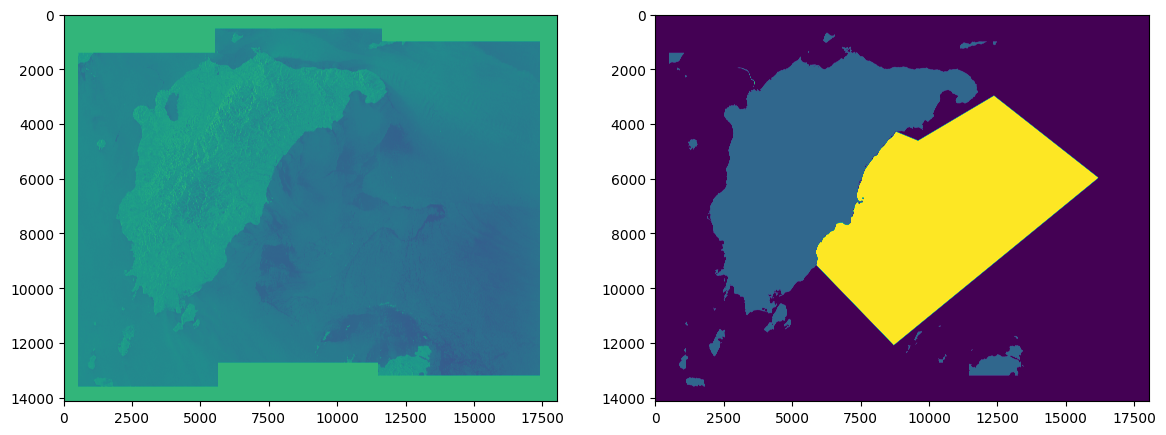

In [218]:
#chanel_img = np.stack([np.pad(netcdf_obj.nc_img, 512), np.pad(numpy_mask, 512)], axis=-1)
chanel_img = np.stack([netcdf_obj.nc_img, numpy_mask], axis=-1)

size = 512
pad_array = np.repeat(size, chanel_img.shape[-1])
zero_pad = np.repeat(0, chanel_img.shape[-1])
chanel_img = np.pad(chanel_img, (pad_array, pad_array, zero_pad))

fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(14, 14)
ax[0].imshow(chanel_img[:, :, 0])
ax[1].imshow(chanel_img[:, :, 1])


220B


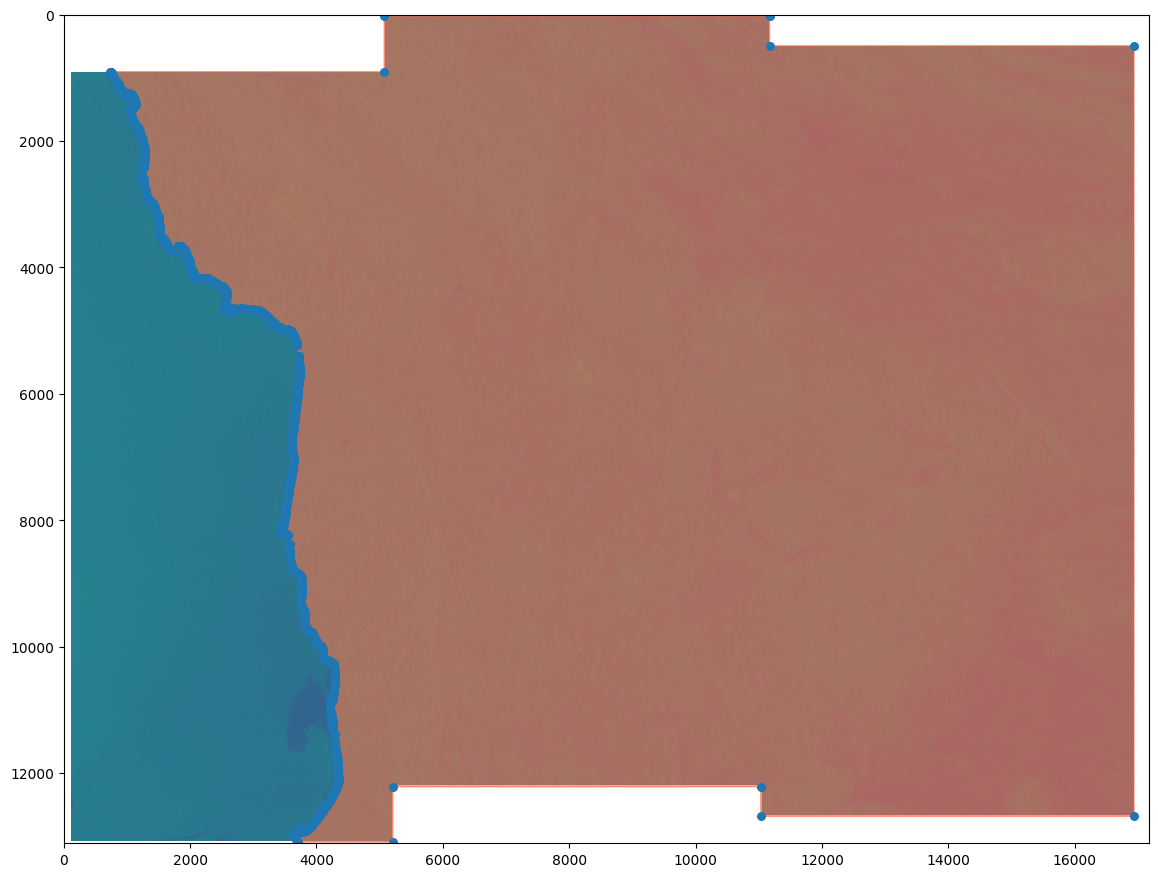

In [25]:
import random
filename_list =  os.listdir("/mnt/camobi_2/PHMG/Sentinel_Acquisition/no_land")
filename = random.choice(filename_list)[-8:-4]


#filename = "E0C1"
filepath_land = "/mnt/camobi_2/PHMG/Sentinel_Acquisition/no_land/no_land_{name}.npz"
filepath = "/mnt/camobi_3/new_data/images_nc/{name}.nc"

contours = np.load(filepath_land.format(name=filename))
netcdf_obj = NetcdfProduct(nc.Dataset(filepath.format(name=filename), 'r'))
print(filename)
fig, ax = plt.subplots()
ax.imshow(netcdf_obj.nc_img)
fig.set_size_inches(14, 14)

edited_contours = []
for poly in contours.values():
    if len(poly) > 100:
        polygon = Polygon(poly, facecolor="tomato", edgecolor="tomato", alpha=0.6)
        ax.add_patch(polygon)
        ax.scatter(poly[:, 0], poly[:, 1], s=30)
        edited_contours.append(poly)  



#np.savez('/mnt/camobi_2/PHMG/Sentinel_Acquisition/no_land/test.npz', *edited_contours)

In [62]:
dict_patches = {'oil': [],
              'ship': [],
              'dark-ocean': [],
              'dark-land': [],
              'land': [],
              'low-wind': [],
              'ocean': []
              }

test = patches.reshape(-1, 512, 512, 2)
for patched_img in test:
    for key, value in dict_label.items():
        if np.any(patched_img[1] == value):
            dict_patches[key].append(patched_img)
        

48

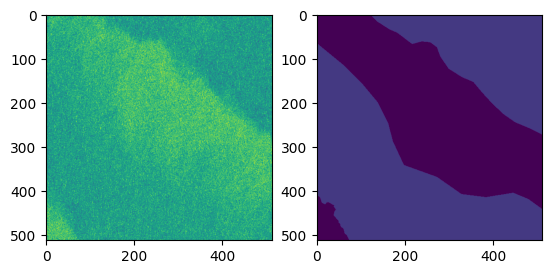

In [63]:
num = 5
img = dict_patches['oil'][num][:, :, 0]
mask = dict_patches['oil'][num][:, :, 1]
#mask = mask[150:200, 250:350]

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(img)
ax[1].imshow(mask, vmin=0, vmax=6)

len(dict_patches['oil'])

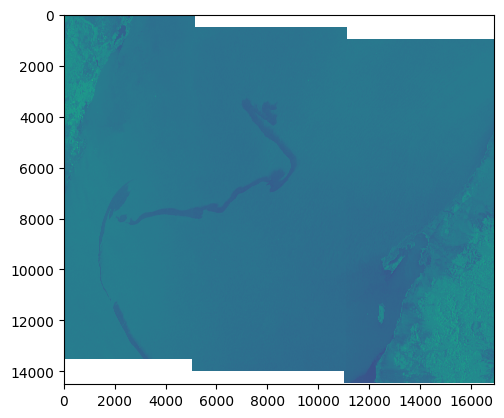

In [70]:
plt.imshow(netcdf_obj.nc_img)

In [65]:
#plt.imshow(numpy_mask)

In [66]:
PATH_TO_GPT = "/home/camobi/snap/bin/gpt"
NO_LAND = "/mnt/camobi_2/PHMG/Sentinel_Acquisition/graphs/NO_LAND.xml"
netcdf_obj.mask_land(PATH_TO_GPT, NO_LAND)

INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL not found on system. Internal GDAL 3.2.1 from distribution will be used. (f0)
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.2.1 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.2.1 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start
76619 [main] INFO serverStartup - Nc4Iosp: NetCDF-4 C library loaded (jna_path='/home/los/.snap/auxdata/netcdf_natives/9.0.0/amd64', libname='netcdf').
76623 [main] INFO serverStartup - NetcdfLoader: set log level: old=0 new=0
76623 [main] INFO serverStartup - Nc4Iosp: set log level: old=0 new=0


....10%....20%....30%....40%....50%....60%....70%....80%....90% done.


In [7]:
test = NetcdfProduct(nc.Dataset("/mnt/camobi_2/PHMG/Sentinel_Acquisition/no_land/test.nc", 'r'))

In [86]:
land_mask = test.nc_img.mask ^ netcdf_obj.nc_img.mask

In [21]:
test = NetcdfProduct(nc.Dataset("/mnt/camobi_3/new_data/new_SAR_img/D0F5.nc", 'r+'))

test.product.createVariable("land_mask", 'u1')
test.product.variables


OSError: [Errno -101] NetCDF: HDF error: '/mnt/camobi_3/new_data/new_SAR_img/D0F5.nc'